In [248]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import statsmodels.api as sm
from datetime import datetime, timedelta

from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import StandardScaler

# Initial Inspection

In [249]:
# Read in the csv file which contains data
df = pd.read_csv('kc_house_data.csv')

In [250]:
# Let's take a look at the first few columns
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [251]:
# Let's look at the data types. Note that date and sqft_basement are string object.
print(df.dtypes)
print('Dataframe shape',df.shape)

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront       float64
view             float64
condition          int64
grade              int64
sqft_above         int64
sqft_basement     object
yr_built           int64
yr_renovated     float64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object
Dataframe shape (21597, 21)


In [252]:
'''
Get the number of NAs for a DataFrame, and the percentage of NAs in the data
'''

def print_NAs(dataframe):
    for column in dataframe:
        num_nas = dataframe[column].isna().sum()
        if num_nas > 0:
            print('Found {0} \t NAs in column \t{1} ({2:0.2f}% of the data)'.format(num_nas, column, 100.*num_nas/len(df)))

print_NAs(df)

Found 2376 	 NAs in column 	waterfront (11.00% of the data)
Found 63 	 NAs in column 	view (0.29% of the data)
Found 3842 	 NAs in column 	yr_renovated (17.79% of the data)


# Plot the waterfront locations on a graph
Not shown here because of library issues but include in powerpoint

In [253]:
# From looking at the map, we found some waterfont properties labeled as NAs that had a water front view.
# Correctly assigning the NAs, requires a deeper analysis. 
# Se decided to drop this column
df = df.drop(columns=["waterfront"])

In [254]:
# "view" column has empty values, will fill with mode
view_mode = df['view'].mode()
print(view_mode[0])
df['view'].fillna(value=view_mode[0],inplace=True)

0.0


In [255]:
# year renovated is ~18% of the data, 
#Convert year renovated to renovated or not variable
df['is_renovated'] = df['yr_renovated'].apply(lambda x: 1 if x>0 else 0)

In [256]:
#sqft basement is a string and some values are missing '?'
df['sqft_basement'].head(7) 

0       0.0
1     400.0
2       0.0
3     910.0
4       0.0
5    1530.0
6         ?
Name: sqft_basement, dtype: object

In [257]:
# the basement sqft can be calculated as the difference 
# between the living area and the above area
df['sqft_basement'] = df['sqft_living'] - df['sqft_above']
#

In [258]:
# but since sqft_basement is dependent on two other variables, lets remove it and
# let's convert it into a has basement or not
df['has_basement'] = df['sqft_basement'].apply(lambda x: 1 if x>0 else 0)


In [259]:
# Looking for outliers

In [260]:
df.bedrooms.unique()

array([ 3,  2,  4,  5,  1,  6,  7,  8,  9, 11, 10, 33])

In [261]:
df[df.bedrooms>30]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,is_renovated,has_basement
15856,2402100895,6/25/2014,640000.0,33,1.75,1620,6000,1.0,0.0,5,...,580,1947,0.0,98103,47.6878,-122.331,1330,4700,0,1


In [262]:
# The 33 bedroom house appears to be a typo as the property has only 1.75 bathrooms, removing..
df = df[df.bedrooms<30]

# Questions
### What is the best month / day to sell ?

In [263]:
from datetime import datetime
df['date'] = df['date'].apply(lambda x: datetime.strptime(x,'%m/%d/%Y'))


In [264]:
df['year_bought'] = df['date'].apply(lambda x: x.year)
df['month_bought'] = df['date'].apply(lambda x: x.month)
df['dofweek_bought'] = df['date'].apply(lambda x: x.weekday())

sold_per_month = df.groupby('month_bought')['price'].count()
soldm = pd.DataFrame(list(sold_per_month),columns=['Nbought'])

sold_per_week = df.groupby('dofweek_bought')['price'].count()
soldw = pd.DataFrame(list(sold_per_week),columns=['Nbought'])

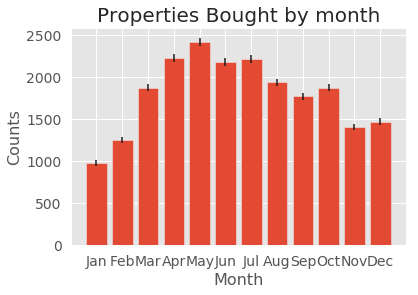

In [265]:

plt.style.use('ggplot')
month_names=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
plt.bar(soldm.index, soldm.Nbought,yerr = np.sqrt(soldm.Nbought)) 
plt.xticks(soldm.index,month_names,fontsize=14);
plt.yticks(fontsize=14);
plt.title('Properties Bought by month',fontsize=20);
plt.xlabel('Month', fontsize=16)
plt.ylabel('Counts',fontsize=16);

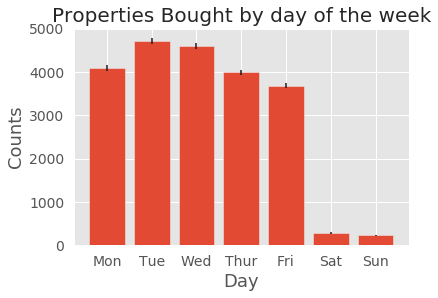

In [266]:
day_names=['Mon','Tue', 'Wed', 'Thur','Fri','Sat','Sun']
plt.bar(soldw.index, soldw.Nbought,yerr = np.sqrt(soldw.Nbought)) 
plt.xticks(soldw.index,day_names,fontsize=14);
plt.yticks(fontsize=14);
plt.title('Properties Bought by day of the week',fontsize=20);
plt.xlabel('Day', fontsize=18)
plt.ylabel('Counts',fontsize=18);

#### Most houses are sold on Tuesdays! Who is buying on a weekend?

### New/Renovated Housing vs. Price
Can how recently a house was built or renovated—it's "newness"—affect it's price per square foot?

In [267]:
df["blt_or_renov"] = df["yr_renovated"]
df.loc[df[df["blt_or_renov"] == 0].index, "blt_or_renov"] = df[df["blt_or_renov"] ==0]["yr_built"]
df["blt_or_renov"].fillna(value=df["yr_built"], inplace=True)

In [268]:
df["price_per_sqft"] = df["price"]/df["sqft_living"]

In [269]:
from statsmodels.formula.api import ols
model = ols(formula="price_per_sqft~blt_or_renov", data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         price_per_sqft   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     1505.
Date:                Wed, 08 May 2019   Prob (F-statistic):          2.71e-318
Time:                        14:00:44   Log-Likelihood:            -1.3143e+05
No. Observations:               21596   AIC:                         2.629e+05
Df Residuals:                   21594   BIC:                         2.629e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     2177.8484     49.337     44.142      0.000    2081.144    2274.553
blt_or_renov    -0.9700      0.025    -38.793      0.000      -1.019      -0.921
==============================================================================
Omnibus:                     4300.894   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9143.552
Skew:                           1.168   Prob(JB):                         0.00
Kurtosis:                       5.170   Cond. No.                     1.35e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.35e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/Users/angelmanzur/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


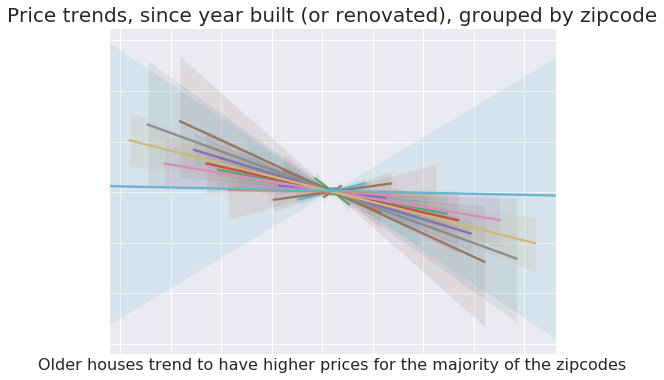

In [270]:
# Lest's fit price per sqft vs year built or renovated and show the strends per zipcode
rsquared = {}
slopes = {}

sns.set(rc={'figure.figsize':(8,6)})

for zipcode in df["zipcode"].unique():
    df_filter = df[df["zipcode"] == zipcode]
    model = ols(formula="price_per_sqft~blt_or_renov", data=df_filter).fit()
    sns.regplot("blt_or_renov","price_per_sqft", data=df_filter, label=zipcode)
    rsquared[zipcode] = model.rsquared
    slopes[zipcode] = model.params[1]

plt.title('Price trends, since year built (or renovated), grouped by zipcode', fontsize = 20)
plt.xlabel('Older houses trend to have higher prices for the majority of the zipcodes', fontsize=16)
plt.ylabel('')
plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
# plt.tick_params(
#     axis='y',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     left='off',
#     labelbottom=False)

In [181]:
print("Top 5 locations where new/renovated housing is cheaper than older. Near Boeing Field airport, Duvall, Renton, Kent, Delridge Except for Delridge, they are all outside downtown Seattle, with Duvall being rural.")
sorted(slopes.items(),key=lambda x:x[1])[0:5]

Top 5 locations where new/renovated housing is cheaper than older. Near Boeing Field airport, Duvall, Renton, Kent, Delridge Except for Delridge, they are all outside downtown Seattle, with Duvall being rural.


[(98075, -1.5333236003573267),
 (98072, -0.9215579923920119),
 (98177, -0.8799497903271807),
 (98019, -0.8450683016985745),
 (98042, -0.8157417799981852)]

In [182]:
print("The locations where new/renovated housing tends to be more expensive than older. Redmond, WA (home of Microsoft), Bellevue, Washington Park, etc..")
pos_slopes = [x[0] for x in slopes.items() if x[1] > 0]
print(pos_slopes)

The locations where new/renovated housing tends to be more expensive than older. Redmond, WA (home of Microsoft), Bellevue, Washington Park, etc..
[98053, 98007, 98112, 98027, 98166, 98070, 98008, 98144, 98034, 98102, 98029]


Taking a look at the relationship for the zipcode with the largest correlation - 98019.


Text(0.5, 1.0, 'Price per sq.ft. vs year  for zipcode 98019')

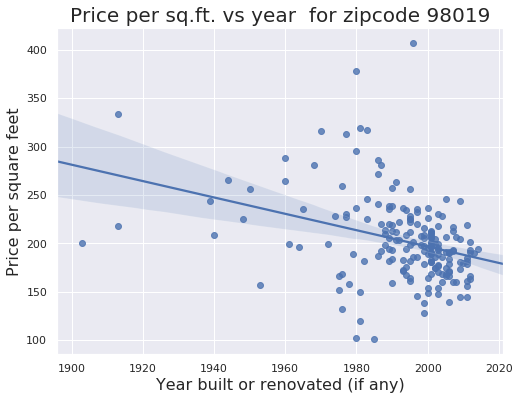

In [183]:
print("Taking a look at the relationship for the zipcode with the largest correlation - 98019.")
sns.regplot("blt_or_renov","price_per_sqft", data=df[df["zipcode"] == 98019], label=zipcode)

plt.xlabel('Year built or renovated (if any)',fontsize=16 )
plt.ylabel('Price per square feet',fontsize=16 )
plt.title('Price per sq.ft. vs year  for zipcode 98019',fontsize=20 )

Maybe we can ignore pre-1980 housing as there's not much and they appear to be outliers


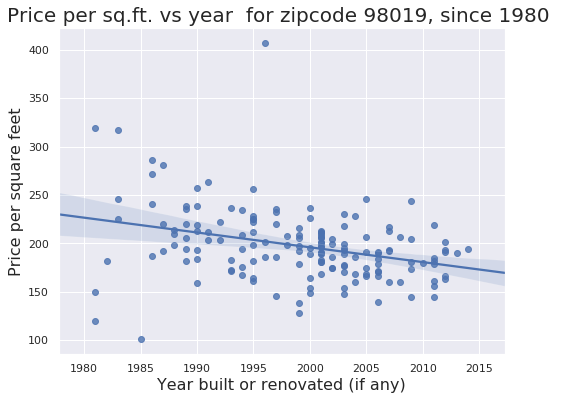

In [184]:
print("Maybe we can ignore pre-1980 housing as there's not much and they appear to be outliers");
sns.regplot("blt_or_renov","price_per_sqft", data=df[(df["zipcode"] == 98019) & (df["blt_or_renov"] >1980)], label=zipcode)

plt.xlabel('Year built or renovated (if any)',fontsize=16 );
plt.ylabel('Price per square feet',fontsize=16 );
plt.title('Price per sq.ft. vs year  for zipcode 98019, since 1980 ',fontsize=20 );

Not a very predictive model but confidence interval bolsters the idea that price per square foot is declining for newer housing in certain zip codes.

## Modelling whole data set

In [185]:
columns_to_drop = ['id', 'zipcode','lat','long',\
                   'date', 'sqft_basement' , 'yr_renovated','price_per_sqft', 'blt_or_renov']
# We are removing these columns as the seller is not is control of this variables


In [186]:
df.drop(columns_to_drop, axis=1, inplace=True)

In [187]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,yr_built,sqft_living15,sqft_lot15,is_renovated,has_basement,year_bought,month_bought,dofweek_bought
0,221900.0,3,1.00,1180,5650,1.0,0.0,3,7,1180,1955,1340,5650,0,0,2014,10,0
1,538000.0,3,2.25,2570,7242,2.0,0.0,3,7,2170,1951,1690,7639,1,1,2014,12,1
2,180000.0,2,1.00,770,10000,1.0,0.0,3,6,770,1933,2720,8062,0,0,2015,2,2
3,604000.0,4,3.00,1960,5000,1.0,0.0,5,7,1050,1965,1360,5000,0,1,2014,12,1
4,510000.0,3,2.00,1680,8080,1.0,0.0,3,8,1680,1987,1800,7503,0,0,2015,2,2


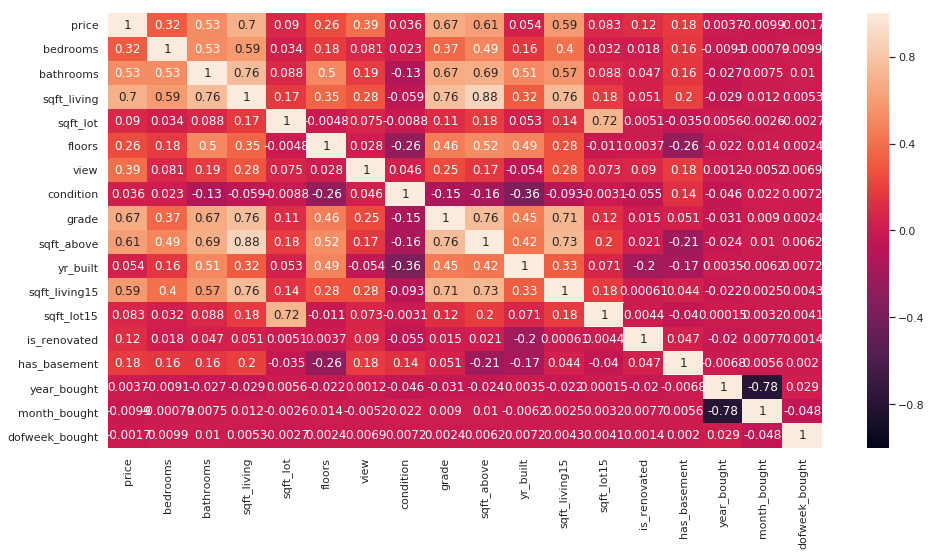

In [188]:
# Let's look at correlations between remaining variables
fig = plt.figure(figsize=(16, 8))
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1)

In [189]:
# Dropping additional columns
# year_bought is all effectively 2014 and 2015. 
# sqft_living15 and sqft_lot15 only has correlations to sqft, 
# which is a more representative variable
more_cols_to_drop = ['year_bought', 'sqft_lot15', 'sqft_living15']

In [190]:
df.drop(more_cols_to_drop, axis=1, inplace=True)

# Standardize the data

In [200]:
b = df['sqft_living']
sqft_living_min = min(b)
sqft_lifving_range = max(b)-min(b)
df['sqft_living'] = (b-sqft_living_min)/sqft_lifving_range

b = df['sqft_above']
sqft_ab_min = min(b)
sqft_ab_range = max(b)-min(b)
df['sqft_above'] = (b-sqft_ab_min)/(sqft_ab_range)

b = df['sqft_lot']
sqft_lot_min = min(b)
sqft_lot_range = max(b)-min(b)
df['sqft_lot'] = (b-sqft_lot_min)/(sqft_lot_range)

b = df['yr_built']                  
yb_min = min(b)
yb_range = max(b)-min(b)
df['yr_built'] = (b-yb_min)/(yb_range)

# standardization
b = df['price']
y = np.log(b)
# price_mean = b.mean()
# price_std = b.std()
# y = (b-price_mean)/(price_std)


In [201]:
#Lets select our predictor data frame
X = df.drop(columns=['price'])

In [202]:
# Let's split the data into train and test data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
print('Train length ',len(X_train), len(y_train))
print('Test length ',len(X_test), len(y_test))

Train length  17276 17276
Test length  4320 4320


In [203]:
# Let's use sklearn.feture selection to find out which predictors are the most important

#Lets do a loop over all of them, fit a model and calculates the MSE.

from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error


linreg = LinearRegression()

npred_arr = []
mse_train = []
mse_test=[]
top_predictors = []
for npreds in range(1,len(X_train.columns)):

    selector = RFE(linreg, n_features_to_select = npreds)
    selector = selector.fit(X_train, y_train)
    features_bool = np.array(selector.support_)
    features = np.array(X_train.columns)
    top = features[features_bool]
#     print(top)
#    linreg.fit(X_train, y_train)
    y_hat_train = selector.predict(X_train)
    y_hat_test = selector.predict(X_test)
    
    top_predictors.append(top)
    npred_arr.append(npreds)
    train_mse = mean_squared_error(y_train, y_hat_train)
    test_mse = mean_squared_error(y_test, y_hat_test)
    mse_train.append(train_mse)
    mse_test.append(test_mse)

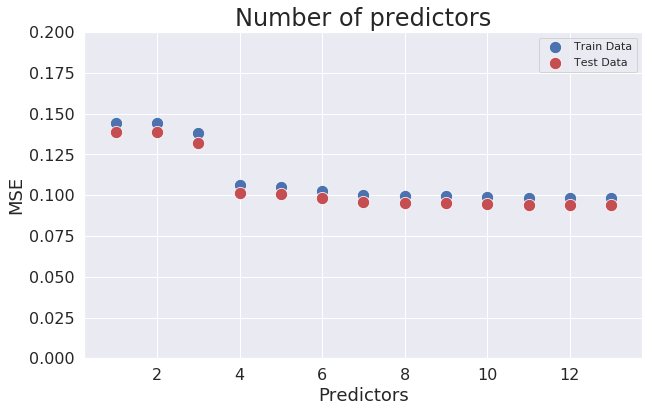

In [246]:
# Let's plot the MSE results vs the number of predictos
fig = plt.figure(figsize=(10,6))
sns.scatterplot(npred_arr, mse_train,label='Train Data',s=150,color='b')
sns.scatterplot(npred_arr, mse_test,label='Test Data',s=150,color='r')
plt.xlabel('Predictors',fontsize=18)
plt.title('Number of predictors',fontsize=24)

# plt.xticks(npred_arr,X_train.columns,rotation='vertical',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(0.0, 0.2)
plt.ylabel('MSE', fontsize=18);

In [205]:
# From this plot we see that adding more predictos improves the model, but after 4 predictors improvement is minimal
for preds in top_predictors:
    print('Top ', len(preds),': ',preds)

Top  1 :  ['sqft_living']
Top  2 :  ['sqft_living' 'sqft_above']
Top  3 :  ['sqft_living' 'sqft_above' 'yr_built']
Top  4 :  ['sqft_living' 'grade' 'sqft_above' 'yr_built']
Top  5 :  ['sqft_living' 'grade' 'sqft_above' 'yr_built' 'has_basement']
Top  6 :  ['sqft_living' 'floors' 'grade' 'sqft_above' 'yr_built' 'has_basement']
Top  7 :  ['sqft_living' 'floors' 'view' 'grade' 'sqft_above' 'yr_built'
 'has_basement']
Top  8 :  ['bathrooms' 'sqft_living' 'floors' 'view' 'grade' 'sqft_above' 'yr_built'
 'has_basement']
Top  9 :  ['bathrooms' 'sqft_living' 'floors' 'view' 'grade' 'sqft_above' 'yr_built'
 'is_renovated' 'has_basement']
Top  10 :  ['bathrooms' 'sqft_living' 'floors' 'view' 'condition' 'grade'
 'sqft_above' 'yr_built' 'is_renovated' 'has_basement']
Top  11 :  ['bedrooms' 'bathrooms' 'sqft_living' 'floors' 'view' 'condition' 'grade'
 'sqft_above' 'yr_built' 'is_renovated' 'has_basement']
Top  12 :  ['bedrooms' 'bathrooms' 'sqft_living' 'sqft_lot' 'floors' 'view'
 'condition' 'gr

In [206]:
# We pick the top 7 variables as it has more vairables the seller can control without adding to many
fields = top_predictors[6]

model = sm.OLS(y_train, sm.add_constant(X_train[fields])).fit()

In [207]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.641
Model:                            OLS   Adj. R-squared:                  0.641
Method:                 Least Squares   F-statistic:                     4401.
Date:                Wed, 08 May 2019   Prob (F-statistic):               0.00
Time:                        12:42:24   Log-Likelihood:                -4622.9
No. Observations:               17276   AIC:                             9262.
Df Residuals:                   17268   BIC:                             9324.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           11.1222      0.021    539.526      0.000      11.082      11.163
sqft_living      1.6906      0.134     12.634      0.000       1.428       1.953
floors           0.1211      0.006     20.835      0.000       0.110       0.132
view             0.0674      0.003     20.006      0.000       0.061       0.074
grade            0.2275      0.004     64.688      0.000       0.221       0.234
sqft_above       0.5155      0.107      4.832      0.000       0.306       0.725
yr_built        -0.5945      0.011    -51.702      0.000      -0.617      -0.572
has_basement     0.1357      0.009     14.906      0.000       0.118       0.153
==============================================================================
Omnibus:                       70.227   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               85.226
Skew:                          -0.085   Prob(JB):                     3.11e-19
Kurtosis:                       3.299   Cond. No.                         557.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [208]:

y_predict_test = model.predict(sm.add_constant(X_test[fields]))

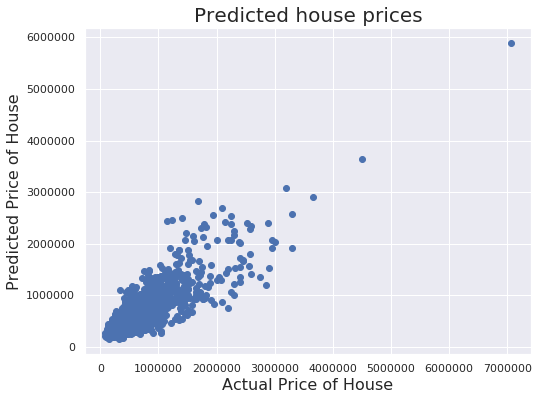

In [209]:
fig = plt.figure(figsize=(8,6))
ax = plt.gca()
plt.scatter(np.exp(y_test), np.exp(y_predict_test));
# plt.plot([-5, 30], [-5, 30], c='red', linestyle='--');
plt.title('Predicted house prices', fontsize=20);
plt.xlabel('Actual Price of House',fontsize=16);
plt.ylabel('Predicted Price of House',fontsize=16);
# ax.set_xscale('log')
# ax.set_yscale('log')

In [210]:
y_predict_train = model.predict(sm.add_constant(X_train[fields]))

In [211]:
from sklearn.metrics import mean_squared_error
train_mse = mean_squared_error(y_train, y_predict_train)
test_mse = mean_squared_error(y_test, y_predict_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 0.09998891163867407
Test Mean Squarred Error: 0.09599346049291385


In [212]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.641
Model:                            OLS   Adj. R-squared:                  0.641
Method:                 Least Squares   F-statistic:                     4401.
Date:                Wed, 08 May 2019   Prob (F-statistic):               0.00
Time:                        12:43:11   Log-Likelihood:                -4622.9
No. Observations:               17276   AIC:                             9262.
Df Residuals:                   17268   BIC:                             9324.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           11.1222      0.021    539.526      0.000      11.082      11.163
sqft_living      1.6906      0.134     12.634      0.000       1.428       1.953
floors           0.1211      0.006     20.835      0.000       0.110       0.132
view             0.0674      0.003     20.006      0.000       0.061       0.074
grade            0.2275      0.004     64.688      0.000       0.221       0.234
sqft_above       0.5155      0.107      4.832      0.000       0.306       0.725
yr_built        -0.5945      0.011    -51.702      0.000      -0.617      -0.572
has_basement     0.1357      0.009     14.906      0.000       0.118       0.153
==============================================================================
Omnibus:                       70.227   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               85.226
Skew:                          -0.085   Prob(JB):                     3.11e-19
Kurtosis:                       3.299   Cond. No.                         557.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [243]:
user_variables = ['sqft_living', 'floors','view','grade','has_basement']
for var in user_variables:
    if var != 'sqft_living':
        delta_per_price = (np.exp(model.params[var]) - 1)
        print('Variables ',var,'\t  adds {0:0.2f}%'.format(delta_per_price*100))


Variables  floors 	  adds 12.87%
Variables  view 	  adds 6.97%
Variables  grade 	  adds 25.55%
Variables  has_basement 	  adds 14.53%


12800

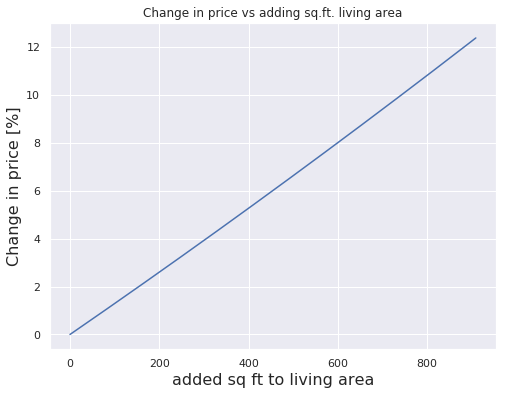

In [242]:
price_change = []
sqft = []
for i in range(370,1280):
    sqft.append(i-370)
    convert_one_sqft = (i-sqft_living_min)/sqft_lifving_range
    delta_per_price = (np.exp(model.params['sqft_living']*convert_one_sqft) - 1)
    price_change.append(delta_per_price*100)
    convert_one_sqft = (i-sqft_living_min)/sqft_lifving_range
#     price_change.append(convert_one_sqft)
plt.plot(sqft, price_change)
plt.xlabel("added sq ft to living area",fontsize=16)
plt.ylabel('Change in price [%]',fontsize=16)
plt.title('Change in price vs adding sq.ft. living area')
sqft_lifving_range-sqft_living_min